In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Lecture de tous les mots
words = open('dataset/names.txt', 'r').read().splitlines()
words [:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
#Création des dictionnaires
chars = sorted(list(set(''.join(words)))) # estraction de chaque caracère de la liste de mots
stoi = {s:i+1 for i,s in enumerate(chars)} # Création d'un liste en commençant à l'indice 1 ou chaque caractère est associcé à un index
stoi['.'] = 0 #jout du caractère "." à l'indice 0
itos = {i:s for s,i in stoi.items()} # Création d'une liste inverse pour avoir le nombre et la corespondance du caractere
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
######################################################
## Création des datasets d'entainement/ dev / test ###
######################################################
block_size = 3 # taille du contexte dans cet exemple 

# Création d'une fonction réutilisatble
def build_dataset(words):
    
    
    X, Y = [], [] #Création de deux liste X pour les entrées et Y pour la sortie attendue
    
    for w in words:
        context = [0] * block_size # On initie le contexte avec [0, 0, 0]
        for ch in w + '.': # Pour chauqe catactère du mot
    
            ix = stoi[ch] # On récupère la valeur du nombre correspondant à la lettre
            X.append(context) # On ajoute le contexte à la liste X
            Y.append(ix) # On ajoute la valeur numérique du caractère à la liste Y
            
            # On jette le premier élément du contexte et on d&calle tout a gauche
            #et on ajoute la valeur numérique de la lettre dans le contexte
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    #print(X.shape, Y.shape)
    return X, Y

# Utilisation de la fonction pour créer les différents dataset
import random
random.seed(42)
random.shuffle(words) # On mélange aléatoirment la liste de mot
n1 = int(0.8*len(words))
print(n1)
n2 = int(0.9*len(words))
print(n2)

Xtr, Ytr = build_dataset(words[:n1]) # On créer une liste avec les mots compris dans le mot 1 et le mot 25626 (80%)
Xdev, Ydev = build_dataset(words[n1:n2]) # On créer une liste avec les mots compris  entre le mot 25626 et le mot 28829 (10%)
Xte, Yte = build_dataset(words[n2:]) # On créer une liste avc les mots après 28829 (10%)

print('dataset d\'entrainement : ', Xtr.shape[0], ' trigrammes')
print('dataset de dev / Validation : ', Xdev.shape[0], ' trigrammes')
print('dataset de test : ', Xte.shape[0], ' trigrammes')

25626
28829
dataset d'entrainement :  182625  trigrammes
dataset de dev / Validation :  22655  trigrammes
dataset de test :  22866  trigrammes


In [5]:
######################################################
################### PARAMÈTRES #######################
######################################################
n_embd = 10 #Taille de l'embedding
n_hidden = 200 #Nombre de neuronne dans la couche cachée du MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),                 generator = g) # Couche d'embedding
W1 = torch.randn((n_embd* block_size, n_hidden),      generator = g) # Poids Hidden Layer
b1 = torch.randn(n_hidden,                            generator = g) # Biais Hidden layer
W2 = torch.randn((n_hidden, vocab_size),              generator = g) # Poids sortie
b2 = torch.randn(vocab_size,                          generator = g) # Biais sortie

parameters = [C, W1, W2, b1, b2]

# Afficher le nombre de paramètre
print('Notre modèle compte ',sum(p.nelement() for p in parameters), ' paramètres')

# Si on ne fait pas ça on a cette erreur
# RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn
for p in parameters:
    p.requires_grad = True


Notre modèle compte  11897  paramètres


In [6]:
lri, lossi, stepi = [], [], [] ## Stockage des learning rates essayé avec les les loss asosciés 

In [7]:
######################################################
################### ENTRAINEMENT #####################
######################################################
max_steps = 200000
batchSize = 128


for i in range(max_steps): 

    #Construction d'un minibach
    ix = torch.randint(0, Xtr.shape[0], (batchSize,), generator=g) #Cette ligne tire 32 indices aléatoires dans le dataset pour construire un mini-batch.
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y 
    
    # 1) Forward pass

    # 1.1) Embedding
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # Concaténation des vecteurs
    hpreact = embcat @ W1 + b1 # Couche cachée de pré activation
    h = torch.tanh(hpreact) # Couche cachée)
    logits = h @ W2 + b2  # Couche de sortie
    loss = F.cross_entropy(logits, Yb) # Calcul de la loss (exp + counts / counts.sum ...)

     

    # 2) Backprop
    for p in parameters:
        p.grad = None  
    loss.backward() 

    # 3) Mise à jour du lr selon l'avancée de l'entrainement
    lr = 0.1 if i < 100000 else 0.01

    # 3) Gradient descent >> Mise à jour des poids
    for p in parameters:
        p.data += -lr * p.grad    # descente de gradiant

    # Track stats
    if i % 10000 == 0: # print
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 26.9832
  10000/ 200000: 2.2707
  20000/ 200000: 2.5485
  30000/ 200000: 2.1790
  40000/ 200000: 2.2564
  50000/ 200000: 2.3769
  60000/ 200000: 2.3600
  70000/ 200000: 2.2799
  80000/ 200000: 2.2705
  90000/ 200000: 2.0548
 100000/ 200000: 2.1728
 110000/ 200000: 2.1372
 120000/ 200000: 1.9034
 130000/ 200000: 2.0622
 140000/ 200000: 2.3261
 150000/ 200000: 2.1707
 160000/ 200000: 2.0761
 170000/ 200000: 2.3466
 180000/ 200000: 2.1233
 190000/ 200000: 2.1971


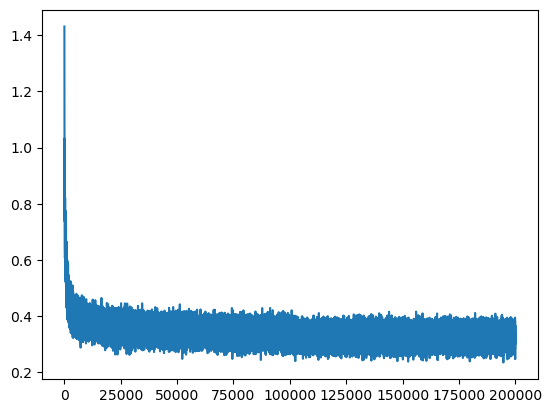

In [8]:
plt.plot(lossi)

In [9]:
###################################################################
##### ÉVALUATION DE LA LOSS DU MODÈLE SUR LES JEUX DE DONNÉES #####
######### TRAIN / VAL / TEST SANS ENTRAINER LE MODELE #############
###################################################################

@torch.no_grad()  # on désactive le gradiant car pas de backpropagation ici donc plus efficient
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    # Embedding lookup
    emb = C[x]  # (N, block_size, n_embd)

    # Concatenate embeddings
    embcat = emb.view(emb.shape[0], -1)  # (N, block_size * n_embd)

    # Hidden layer
    h = torch.tanh(embcat @ W1 + b1)  # (N, n_hidden)

    # Output layer
    logits = h @ W2 + b2  # (N, vocab_size)

    # Loss
    loss = F.cross_entropy(logits, y)

    print(split, loss.item())


# Evaluate losses
split_loss('train')
split_loss('val')


train 2.122871160507202
val 2.160916328430176


In [10]:
# Génération de nom depuis le modèle entriané
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break

    # decode and print the generated word
    print(''.join(itos[i] for i in out))


carmah.
amelle.
khi.
mili.
taty.
skanden.
jazonel.
delyah.
jareei.
nermara.
chaiir.
kaleigh.
ham.
pris.
quinn.
shor.
raiviabi.
watthonderryxin.
kael.
dura.


In [ ]:
Reprendre à 04:53